# Prediciendo el Éxito de los Estudiantes Usando Estadísticas de Interacción en un Entorno de Aprendizaje Virtual

Adaptado por [Abril Vento](https://github.com/davento) y [Jean Paul Melendez Cabezas](https://github.com/jeanpaulmc), tomando como base [el trabajo de Josh Johnson](https://github.com/Caellwyn/ou_student_predictions).

## Requisitos

Primero asegurar que el environment se haya setteado correctamente. Se recomienda usar conda y pip:

```bash
conda env create --file environment.yml 
conda activate student-prediction
pip install -r requirements.txt
```

En caso estar corriendo este notebook desde un editor de texto, asegurar que el Kernel utilizado sea el correcto.

Una vez hecho esto, el notebook se debería poder correr sin dificultades. Empezar por cargar las librerías:

In [41]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras import optimizers, layers
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
model_evaluate_presentation, cross_val_presentation, GridSearchPresentationCV, \
registration_correlations, dist_by_course, graph_model_history

#from dython.nominal import associations

import pickle

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)
tf.keras.backend.set_floatx('float64')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocesamiento

Los datos deben prepararse apropiadamente para permitir su análisis. Se realizó el mismo preprocesamiento que el trabajo original, usando la función `load_OU_data()`.

In [16]:
# cersiorarse que este en el working directory correcto
# print(os.getcwd())
# os.chdir("..")
df = load_OU_data(prediction_window = .5)
df.drop(columns = ['id_student','region','highest_education',\
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,code_presentation,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,Pass,26.0,121.0,628.0,0.500000,81.000000
1,AAA,2013J,Pass,45.0,266.0,896.0,0.333333,69.000000
2,AAA,2013J,Pass,68.0,371.0,1231.0,0.500000,72.333333
3,AAA,2013J,Pass,40.0,207.0,747.0,0.333333,49.500000
4,AAA,2013J,Pass,70.0,365.0,1271.0,0.500000,74.000000


In [17]:
test_df = df[df['code_presentation'] == '2014J']
train_df = df[df['code_presentation'] != '2014J']

# esta variable se usará en el análisis de errores más adelante
y_test_uncollapsed = test_df['final_result'].reset_index(drop=True)

# se juntan los resultados en dos clases
train_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in train_df['final_result']])
test_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in test_df['final_result']])

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

#the cross validator processes data as it's validating, but we want a set for final evaluation, too.
X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

## Modelado

### Regresión Logística

Primero se intenta usando una simple regresión logística usando una FMS

0.786917582492217

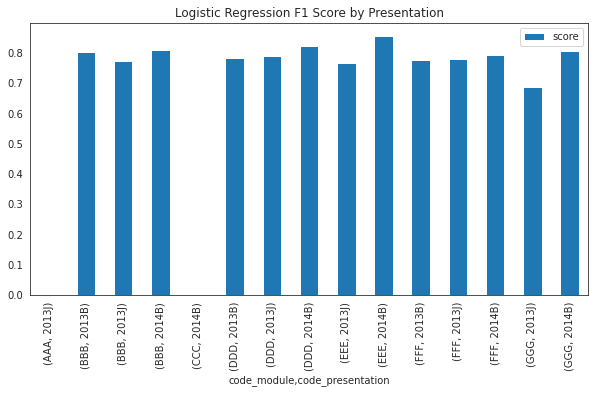

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.802534
            2013J              0.771309
            2014B              0.807003
CCC         2014B                   NaN
DDD         2013B              0.781955
            2013J              0.787157
            2014B               0.82325
EEE         2013J              0.766378
            2014B              0.855823
FFF         2013B              0.774221
            2013J              0.779393
            2014B              0.790566
GGG         2013J               0.68543
            2014B               0.80491

0.7412443874278384
                    precision    recall  f1-score   support

Needs Intervention       0.62      0.67      0.64      2727
   No Intervention       0.81      0.78      0.80      5068

          accuracy                           0.74      7795
         macro avg       0.72      0.72      0.72      7795
      weighted avg       0.75      0.74      0.74      7795



In [4]:
model = LogisticRegression()
scores = cross_val_presentation(model, train_df, scoring = 'accuracy', verbose = 1)
scores.plot(kind = 'bar', figsize = (10,5), title = 'Logistic Regression F1 Score by Presentation')
plt.show()
display(scores)
y_pred = model.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Luego, se intenta usar GridsearchCV para conseguir mejores hiperparámetros

trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7868812936677083
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'sag'}
average score:  0.7868812936677083
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'saga'}
average score:  0.7868812936677083
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7868812936677083
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7868812936677083
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'sag'}
average score:  0.7868812936677083
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'saga'}
average score:  0.7868812936677083
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7868812936677083
trying:
{'C': 0.1, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
aver

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B               0.80924
            2013J              0.789916
            2014B              0.812126
CCC         2014B                   NaN
DDD         2013B              0.769066
            2013J              0.786436
            2014B              0.816133
EEE         2013J              0.777503
            2014B               0.84658
FFF         2013B              0.776817
            2013J              0.790139
            2014B               0.79434
GGG         2013J              0.698675
            2014B              0.810078

cross validated accuracy score:
0.7905421745974255
validation accuracy: 
0.742142398973701
validation set confusion matrix


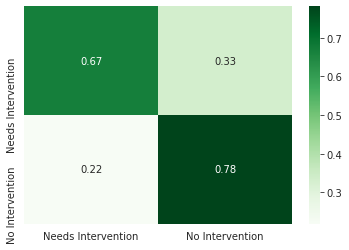

In [5]:
LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111],
          'C':[.001,.01,.1]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111],
          'C':[.001,.01,.1]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.4,.7,.9]},
          {'solver':['saga','liblinear'],
          'penalty':['l1'],
          'C':[.001,.01,.1]}]


LRgrid = GridSearchPresentationCV(LogisticRegression(), LRparams,
                                scoring='accuracy', verbose = 1)

LRgrid.fit(train_df)
LRmodel = score_grid(LRgrid, X_test_transformed, y_test)
pickle.dump(LRmodel,open('../models/LRmodel3.pkl','wb'))

Model Hyperparamters:
LogisticRegression(C=0.1, l1_ratio=0.9, penalty='l1', random_state=111,
                   solver='liblinear')
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.803279
            2013J              0.772509
            2014B              0.806149
CCC         2014B                   NaN
DDD         2013B              0.778733
            2013J              0.785714
            2014B              0.826809
EEE         2013J              0.771323
            2014B              0.855823
FFF         2013B              0.775952
            2013J              0.778761
            2014B              0.790566
GGG         2013J              0.687638
            2014B               0.80491

Mean validation scores is:
0.7875510375234419
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.62      0.67      0.65      2727
   No Intervention       0.81      0.78      0.80      5068

          accuracy                           0.74      7795
         macro avg       0.72      0.73      0.72      7795
      weighted avg       0.75      0.74      0.74      7795



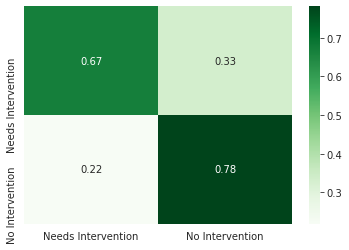

In [6]:
print('Model Hyperparamters:')
print(LRmodel)

scores = cross_val_presentation(LRmodel, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))


LRmodel.fit(X_train_transformed,y_train_transformed)
y_pred = LRmodel.predict(X_test_transformed)
print('Evaluation on hold-out set.')
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

Se obtuvo una mejora ligera, pero casi indistinguible.

### Decision Tree

trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7827513722889621
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score:  0.7827513722889621
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7827513722889621
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score:  0.7827513722889621
trying:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7827513722889621
trying:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.801043
            2013J              0.785714
            2014B              0.758326
CCC         2014B                   NaN
DDD         2013B              0.801289
            2013J              0.792929
            2014B              0.793594
EEE         2013J              0.836836
            2014B               0.80037
FFF         2013B              0.791522
            2013J              0.787611
            2014B              0.787736
GGG         2013J              0.699779
            2014B              0.739018

cross validated accuracy score:
0.7827513722889621
validation accuracy: 
0.7241821680564464
validation set confusion matrix


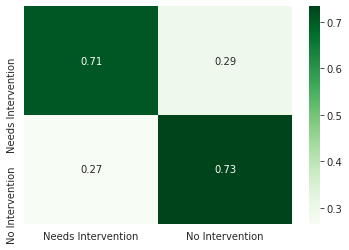

In [7]:
DTparams = {'criterion':['entropy'],
           'splitter':['best'],
           'max_depth':[4,20],'min_samples_split':[.5,.6],
           'max_features':[4,5],'random_state':[111]}


DTgrid = GridSearchPresentationCV(DecisionTreeClassifier(), DTparams,
                                scoring='accuracy', verbose = 1)

DTgrid.fit(train_df)
DTmodel = score_grid(DTgrid, X_test_transformed, y_test)
pickle.dump(DTmodel,open('../models/DTmodel3.pkl','wb'))

Model Hyperparamters:
DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=5,
                       min_samples_split=0.6, random_state=111)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.801043
            2013J              0.785714
            2014B              0.758326
CCC         2014B                   NaN
DDD         2013B              0.801289
            2013J              0.792929
            2014B              0.793594
EEE         2013J              0.836836
            2014B               0.80037
FFF         2013B              0.791522
            2013J              0.787611
            2014B              0.787736
GGG         2013J              0.699779
            2014B              0.739018

Mean validation scores is:
0.7827513722889621
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.60      0.68      0.64      2727
   No Intervention       0.81      0.76      0.78      5068

          accuracy                           0.73      7795
         macro avg       0.71      0.72      0.71      7795
      weighted avg       0.74      0.73      0.73      7795



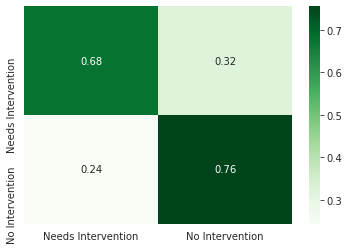

In [8]:
print('Model Hyperparamters:')
print(DTmodel)

scores = cross_val_presentation(DTmodel, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))

DTmodel.fit(X_train_transformed,y_train_transformed)
y_pred = DTmodel.predict(X_test_transformed)
print('Evaluation on hold-out set.')
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

### Random Forest

trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.1, 'n_estimators': 150}
average score:  0.7872693584998119
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.1, 'n_estimators': 200}
average score:  0.7865695105939363
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.3, 'n_estimators': 150}
average score:  0.7892447500365982
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.3, 'n_estimators': 200}
average score:  0.7888390628838824
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0.1, 'n_estimators': 150}
average score:  0.7900252722687082
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0.1, 'n_estimators': 200}
average score:  0.7897636131768488
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.802534
            2013J              0.773709
            2014B              0.773698
CCC         2014B                   NaN
DDD         2013B               0.79377
            2013J              0.790765
            2014B              0.811388
EEE         2013J              0.818294
            2014B               0.83549
FFF         2013B              0.785467
            2013J              0.804678
            2014B              0.793396
GGG         2013J              0.704194
            2014B              0.782946

cross validated accuracy score:
0.7900252722687082
validation accuracy: 
0.731879409878127
validation set confusion matrix


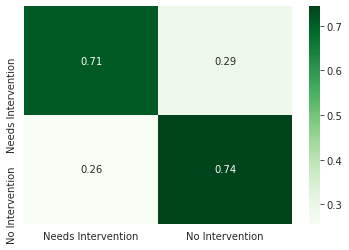

In [9]:
RFparams = {'n_estimators':[150,200],
           'criterion':['entropy'],
           'max_depth':[4,7],
           'min_samples_split':[.1,.3],
           'max_samples':[.7,None]}
           
RFgrid = GridSearchPresentationCV(RandomForestClassifier(n_jobs = -1,
                                                        random_state=111), 
                                  RFparams, scoring = 'accuracy', verbose = 1)

RFgrid.fit(train_df)

RFmodel = score_grid(RFgrid, X_test_transformed, y_test)
pickle.dump(RFmodel, open('../models/RFmodel3.pkl','wb'))

Model Hyperparamters:
RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=0.3,
                       n_estimators=200, n_jobs=-1, random_state=111)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.803279
            2013J              0.765306
            2014B              0.757472
CCC         2014B                   NaN
DDD         2013B              0.799141
            2013J              0.791486
            2014B              0.799526
EEE         2013J              0.824475
            2014B              0.804067
FFF         2013B              0.788062
            2013J              0.799621
            2014B              0.788679
GGG         2013J              0.699779
            2014B              0.763566

Mean validation scores is:
0.7834198590902164
                    precision    recall  f1-score   support

Needs Intervention       0.59      0.71      0.65      2727
   No Intervention       0.83      0.74      0.78      5068

          accuracy                           0.73      7795
         macro avg       0.71      0.72      0.71      7795
      weighted avg       0.75      0.73      0.73      7795



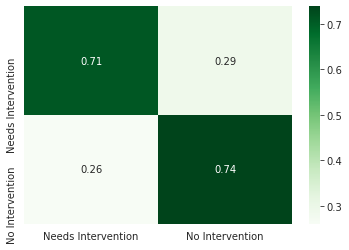

In [10]:
print('Model Hyperparamters:')
print(RFmodel)

scores = cross_val_presentation(RFmodel, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))

RFmodel.fit(X_train_transformed,y_train_transformed)
y_pred = RFmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

### K-Nearest Neighbors

trying:
{'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
average score:  0.7792949881032712
trying:
{'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
average score:  0.7771759396287241
trying:
{'n_neighbors': 30, 'p': 2, 'weights': 'distance'}
average score:  0.7792564566778023
trying:
{'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}
average score:  0.77909545037623
trying:
{'n_neighbors': 30, 'p': 5, 'weights': 'distance'}
average score:  0.77994982586067
trying:
{'n_neighbors': 30, 'p': 5, 'weights': 'uniform'}
average score:  0.7784139417081187
trying:
{'n_neighbors': 30, 'p': 10, 'weights': 'distance'}
average score:  0.7797359392077197
trying:
{'n_neighbors': 30, 'p': 10, 'weights': 'uniform'}
average score:  0.7796988510611018
trying:
{'n_neighbors': 30, 'p': 15, 'weights': 'distance'}
average score:  0.7799891640098555
trying:
{'n_neighbors': 30, 'p': 15, 'weights': 'uniform'}
average score:  0.7782893975718582
trying:
{'n_neighbors': 30, 'p': 20, 'weights': 'distance'}
avera

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.804024
            2013J              0.777311
            2014B              0.811272
CCC         2014B                   NaN
DDD         2013B              0.769066
            2013J              0.784993
            2014B              0.829181
EEE         2013J               0.78492
            2014B               0.84658
FFF         2013B              0.765571
            2013J              0.785082
            2014B              0.787736
GGG         2013J              0.699779
            2014B              0.806202

cross validated accuracy score:
0.7885936003749294
validation accuracy: 
0.7430404105195638
validation set confusion matrix


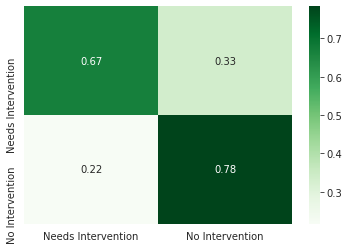

In [11]:
KNNparams = {'n_neighbors':[30, 50, 100, 150, 200, 300],
            'weights':['distance', 'uniform'],
             'p':[1,2,5,10,15,20]}
             
KNNgrid = GridSearchPresentationCV(KNeighborsClassifier(n_jobs = -1), KNNparams, 
                                scoring='accuracy', verbose = 1)

KNNgrid.fit(train_df)
KNNmodel = score_grid(KNNgrid, X_test_transformed, y_test)
pickle.dump(KNNmodel, open('../models/KNNmodel2.pkl','wb'))

Model Hyperparamters:
KNeighborsClassifier(n_jobs=-1, n_neighbors=300, p=20)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.803279
            2013J               0.77491
            2014B              0.811272
CCC         2014B                   NaN
DDD         2013B              0.766917
            2013J              0.787157
            2014B              0.825623
EEE         2013J              0.788628
            2014B               0.84658
FFF         2013B              0.768166
            2013J              0.786979
            2014B              0.784906
GGG         2013J              0.699779
            2014B               0.80491

Mean validation scores is:
0.7883927566575688
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.62      0.67      0.64      2727
   No Intervention       0.81      0.78      0.80      5068

          accuracy                           0.74      7795
         macro avg       0.72      0.73      0.72      7795
      weighted avg       0.75      0.74      0.74      7795



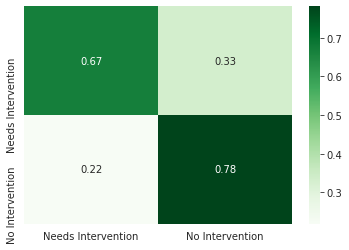

In [12]:
print('Model Hyperparamters:')
print(KNNmodel)

scores = cross_val_presentation(KNNmodel, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))

KNNmodel.fit(X_train_transformed,y_train_transformed)
y_pred = KNNmodel.predict(X_test_transformed)
print('Evaluation on hold-out set.')
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

### Deep Learning

Se volvieron a preparar los datos para trabajar con las redes neuronales profundas:

In [84]:
df_full = load_OU_data(prediction_window=.5)

df_deep = df_full.drop(columns = ['id_student','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'])

df_deep['final_result'] = np.array([1 if w in ['Pass','Distinction'] \
              else 0 for w in df_full['final_result']])

train_df_deep = df_deep[df_deep['code_presentation'] != '2014J']
test_df_deep = df_deep[df_deep['code_presentation'] == '2014J']

X_train_deep = train_df_deep.drop(columns = ['final_result','code_presentation'])
y_train_deep = train_df_deep['final_result']
X_test_deep = test_df_deep.drop(columns = ['final_result','code_presentation'])
y_test_deep = test_df_deep['final_result']

#split 2014J presentations into validation and holdout sets
X_t_deep, X_val_deep, y_t_deep, y_val_deep = train_test_split(X_train_deep, y_train_deep, test_size = .2,
                                                     random_state = 111, shuffle=True)

X_train_transformed_deep, y_train_transformed_deep, X_test_transformed_deep \
                                = process_courses(X_train_deep, y_train_deep, X_test_deep)

X_t_transformed_deep, y_t_transformed_deep, X_val_transformed_deep \
                                = process_courses(X_t_deep, y_t_deep, X_val_deep)

PRauc = tf.keras.metrics.AUC(name = 'PRauc', curve = 'PR', thresholds = [.5])

In [32]:
train_df.shape

(15617, 8)

Los resultados del modelo entrenado en el estudio original se muestran aquí:

98/98 [==============================] - 0s 2ms/step


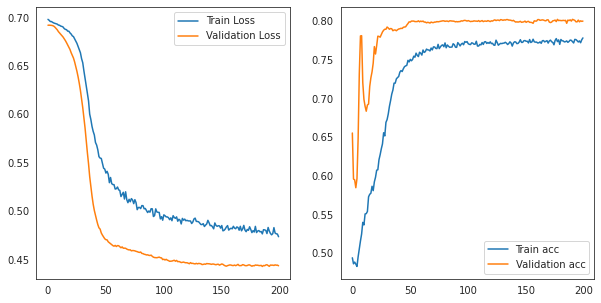

Accuracy on Validation
0.7999359795134443


<AxesSubplot:>

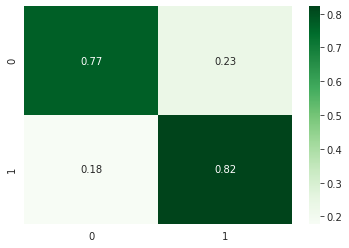

In [45]:
def make_model8():
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=.7)
    optimizer = optimizers.SGD(learning_rate=lr_schedule)    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model8()
modelpath = '../models/densemodel8.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed_deep, y_t_transformed_deep,
                  epochs = 200,
                  validation_data = (X_val_transformed_deep, y_val_deep),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed_deep))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val_deep, y_pred)))
plot_confusion(y_val_deep, y_pred)

### Arquitectura adicional propuesta

Como aporte adicional a lo realizado en el paper, se propuso un modelo nuevo en el que se redujeron la cantidad capas internas (hidden layers) para disminuir el overfit. Cabe mencionar que el modelo nuevo en cuestión es un modelo funcional, no uno secuencial, lo cual hace posible que se creen modelos embebidos (embedded approaches). Asimismo, se prueba el optimizador ADAM, el cual varia el learning rate de forma dinámica dependiendo de la diferencia en el gradient descent.

In [66]:
"""
 modelo nuevo:
 + Se redujeron la cantidad capas internas (hidden layers) para disminuir el overfit
 + El modelo nuevo en cuestión es un modelo funcional, no uno secuencial, lo cual hace posible que se 
 creen modelos embebidos (embedded approaches).
 + Se prueba el optimizador ADAM, el cual varia el learning rate de forma dinámica dependiendo de la diferencia en el gradient descent
"""

def make_modelJP():
    Input_layer = tf.keras.layers.Input(shape = (5,))
    d1 = Dense(50, activation='relu')(Input_layer)
    d2 = Dropout(rate=.2)(d1)
    d3 = Dense(50, activation='relu')(d2)
    d4 = Dropout(rate=.2)(d3)
    d5 = Dense(50, activation='relu')(d4)
    d6 = Dropout(rate=.2)(d5)
    d7 = Dense(20, activation='relu')(d6)
    d8 = Dropout(rate=.2)(d7)
    d9 = Dense(20, activation='relu')(d8)
    d10 = Dropout(rate=.2)(d9)
    d11 = Dense(10, activation='relu')(d10)
    output = Dense(1, activation='sigmoid')(d11)
    model = tf.keras.Model(inputs = [Input_layer], outputs = [output], name = "V")    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model


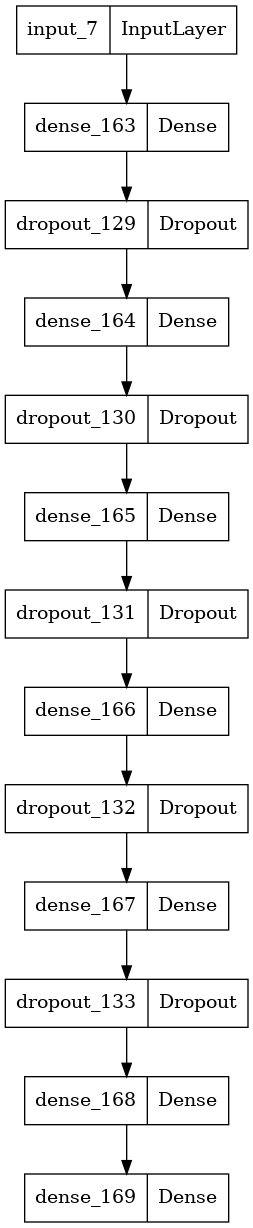

In [90]:
DNNmodel = make_modelJP()
modelpath = '../models/DNNmodelJP.h5'
DNNmodel.save(modelpath)

tf.keras.utils.plot_model(DNNmodel)

In [93]:
mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = DNNmodel.fit(X_t_transformed, y_t_transformed,
                  epochs = 200,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
DNNmodel = load_model(modelpath)

In [ ]:
DNNmodel = load_model(modelpath)

Model Hyperparamters:
Model: "V"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_163 (Dense)           (None, 50)                300       
                                                                 
 dropout_129 (Dropout)       (None, 50)                0         
                                                                 
 dense_164 (Dense)           (None, 50)                2550      
                                                                 
 dropout_130 (Dropout)       (None, 50)                0         
                                                                 
 dense_165 (Dense)           (None, 50)                2550      
                                                                 
 dropout_131 (Dropout)       (None, 50)    

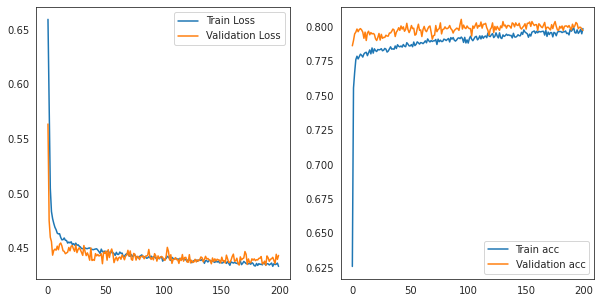

Evaluation on hold-out set.
              precision    recall  f1-score   support

           0       0.61      0.68      0.64      2727
           1       0.82      0.77      0.79      5068

    accuracy                           0.74      7795
   macro avg       0.71      0.72      0.72      7795
weighted avg       0.75      0.74      0.74      7795



<AxesSubplot:>

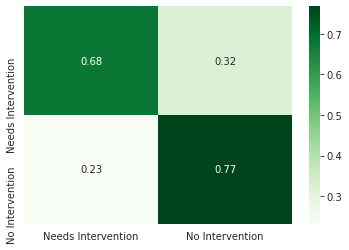

In [94]:
print('Model Hyperparamters:')
print(DNNmodel.summary())
encoder = LabelEncoder()
y_train_binary = encoder.fit_transform(y_train_transformed)
y_test_binary = encoder.transform(y_test)
y_pred = np.round(DNNmodel.predict(X_test_transformed)).astype(int)
graph_model_history(history, metric = 'acc')
print('Evaluation on hold-out set.')
print(classification_report(y_test_binary, y_pred))
plot_confusion(y_test_binary, y_pred, encoder = encoder)

## Evaluación de Resultados

### Evaluación entre modelos no-profundos

In [ ]:
# opcional, solo correr para una visualización rápida
# KNNmodel = pickle.load(open('../models/KNNmodel2.pkl','rb'))
# RFmodel = pickle.load(open('../models/RFmodel3.pkl','rb'))
# DTmodel = pickle.load(open('../models/DTmodel3.pkl','rb'))
# LRmodel = pickle.load(open('../models/LRmodel3.pkl','rb'))

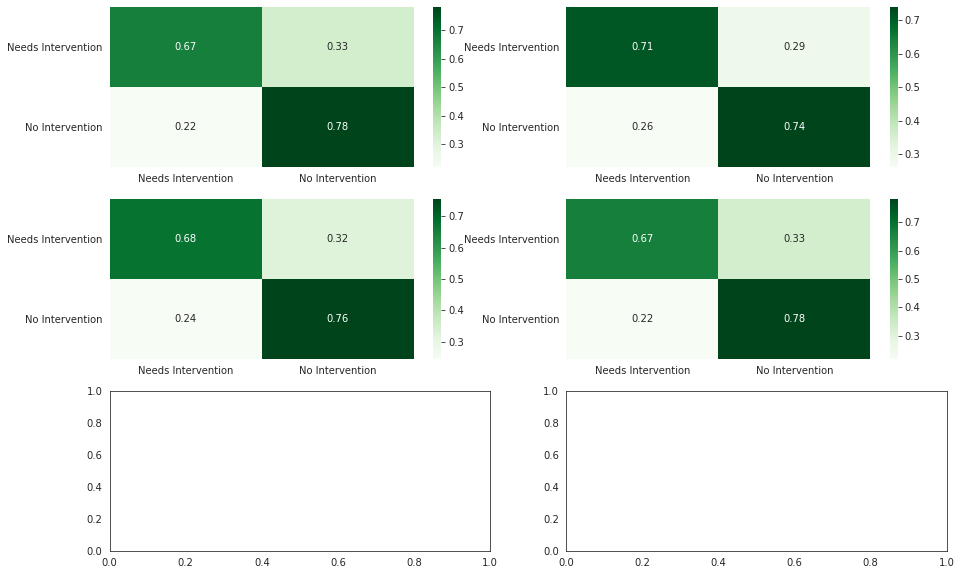

In [36]:
fig, axes = plt.subplots(3,2, figsize=(15,10))
axes = axes.ravel()
models = [KNNmodel, RFmodel, DTmodel, LRmodel]
for i, model in enumerate(models):
    y_pred = model.predict(X_test_transformed)
    plot_confusion(y_test, y_pred, ax=axes[i])
plt.show()

Tras comparar entre los modelos no-profundos, se observa que el modelo RL es el que mejores resultados retorna.

### Ventana de Predicción

In [ ]:
model = load_model('../models/densemodel8.h5')

window_scores = pd.DataFrame(columns = ['Test Set Accuracy'],
                            index = [x*10 for x in range(1,11,1)])

for window in range(1,11,1):
    window_df = load_OU_data(prediction_window=window/10)
    window_df.drop(columns = ['id_student','region','highest_education', 'num_of_prev_attempts',\
                       'imd_band','gender','age_band','disability','studied_credits',
                       'module_presentation_length','date_registration'], inplace = True)
    window_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
                  else 'Needs Intervention' for w in window_df['final_result']])
    window_test_df = window_df[window_df['code_presentation'] == '2014J']
    window_train_df = window_df[window_df['code_presentation'] != '2014J']

    window_X_train = window_train_df.drop(columns = ['final_result','code_presentation'])
    window_y_train = window_train_df['final_result']
    window_X_test = window_test_df.drop(columns = ['final_result','code_presentation'])
    window_y_test = window_test_df['final_result']

    #the cross validator processes data as it's validating, but we want a set for final evaluation, too.
    window_X_train_transformed, window_y_train_transformed, window_X_test_transformed \
                    = process_courses(window_X_train, window_y_train, window_X_test)
    window_y_train_binary = encoder.fit_transform(window_y_train_transformed)
    window_y_test_binary = encoder.transform(window_y_test)
    mc = ModelCheckpoint(filepath='../models/temp_model.h5', save_best_only=True, monitor='val_acc',
                        mode='max')
    model.fit(window_X_train_transformed, window_y_train_binary,
               epochs = 50,
               validation_data = (window_X_test_transformed, window_y_test_binary),
               batch_size = 500,
               verbose = 0,
               callbacks = [mc])
    model = load_model('../models/temp_model.h5')
    y_pred = np.round(model.predict(window_X_test_transformed)).astype(int)
    test_score = accuracy_score(window_y_test_binary, y_pred)
    window_scores.loc[window * 10, 'Test Set Accuracy'] = test_score * 100

fig, ax = plt.subplots(2,1, figsize = (10,10), sharex=False)
ax = ax.ravel()
window_scores.plot(ylim = (60,100), xlim = (0,100),
                  title = 'Prediction Window / Accuracy Tradeoff',
                  ax = ax[0])
full_data = load_OU_data(prediction_window=None)
withdrawals = full_data[full_data['final_result'] == 'Withdrawn']
withdraw_time = withdrawals['date_unregistration']/withdrawals['module_presentation_length'] * 100

sns.kdeplot(data=full_data[full_data.final_result == 'Withdrawn'], ax = ax[1],
            x=withdraw_time, fill=True, legend=True, clip = (0,100),
            cumulative = True).set_title('Cumulative Withdrawals Over Time')
ax[0].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Proportion of Course Elapsed')
ax[1].set_ylabel('Proportion of Withdrawals')
plt.savefig('../figures/accuracy_prediction_window_tradeoff.png')

### Evaluación entre Modelos Profundos
#### Precisión por Curso

244/244 [==============================] - 3s 9ms/step


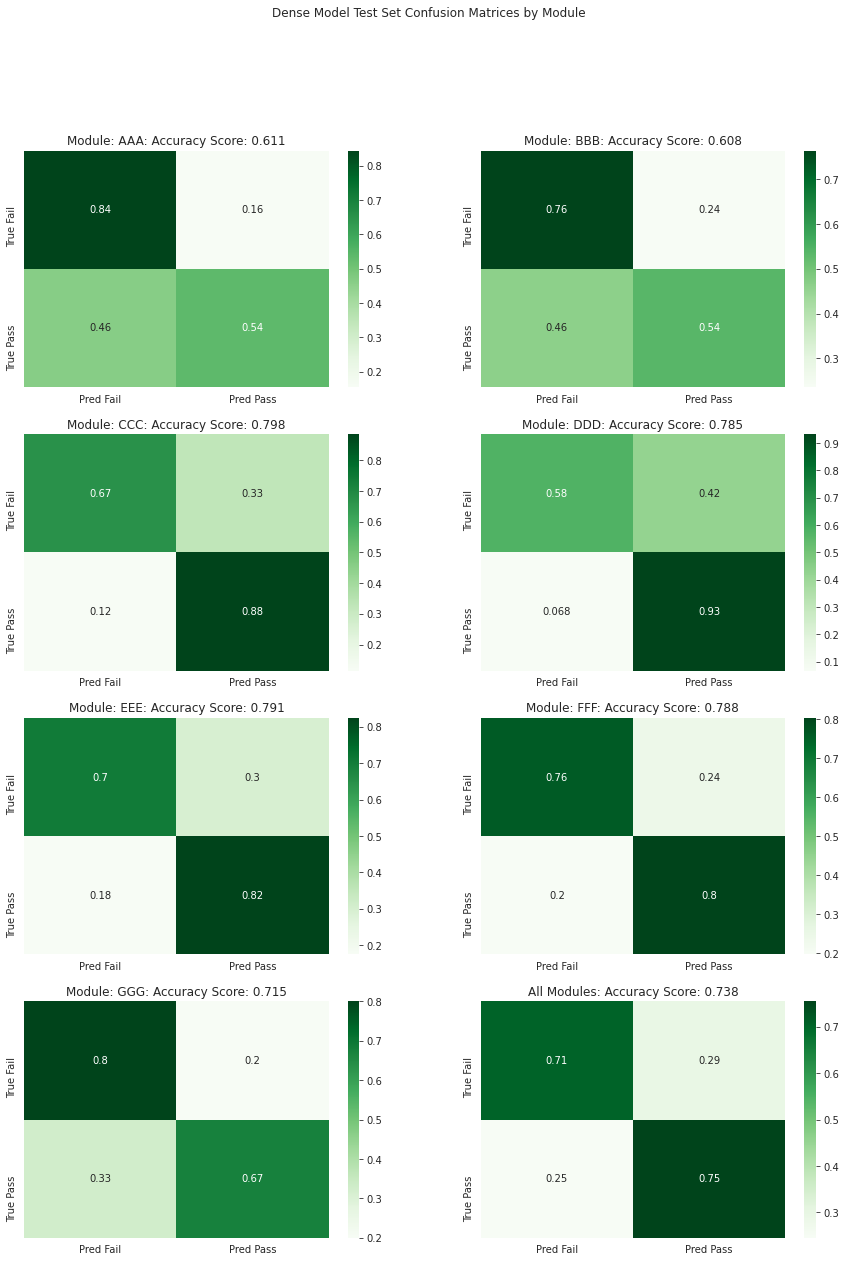

In [77]:
model = keras.models.load_model(f'../models/densemodel8.h5')
y_pred = np.round(model.predict(X_test_transformed_deep))
eval_df = test_df
eval_df['final_result'] = y_test_binary
eval_df['prediction'] = y_pred.astype(int)
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'], index = modules)
fig, axes = plt.subplots(4,2, figsize = (15,20))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = accuracy_score(trues,preds)
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'Module: {module}: Accuracy Score: {round(accuracy,3)}')
    axes[i].set_yticklabels(['True Fail', 'True Pass'])
    axes[i].set_xticklabels(['Pred Fail','Pred Pass'])
plot_confusion(y_test_binary, y_pred, ax = axes[-1])
accuracy = accuracy_score(y_test_binary, y_pred)
axes[-1].set_title(f'All Modules: Accuracy Score: {round(accuracy,3)}')
axes[-1].set_yticklabels(['True Fail', 'True Pass'])
axes[-1].set_xticklabels(['Pred Fail','Pred Pass'])
plt.tight_layout(rect = [0,0,0,0])
plt.savefig('../figures/best_dense_course_confmats.png')
plt.suptitle(f'Dense Model Test Set Confusion Matrices by Module')
plt.show()

244/244 [==============================] - 2s 5ms/step


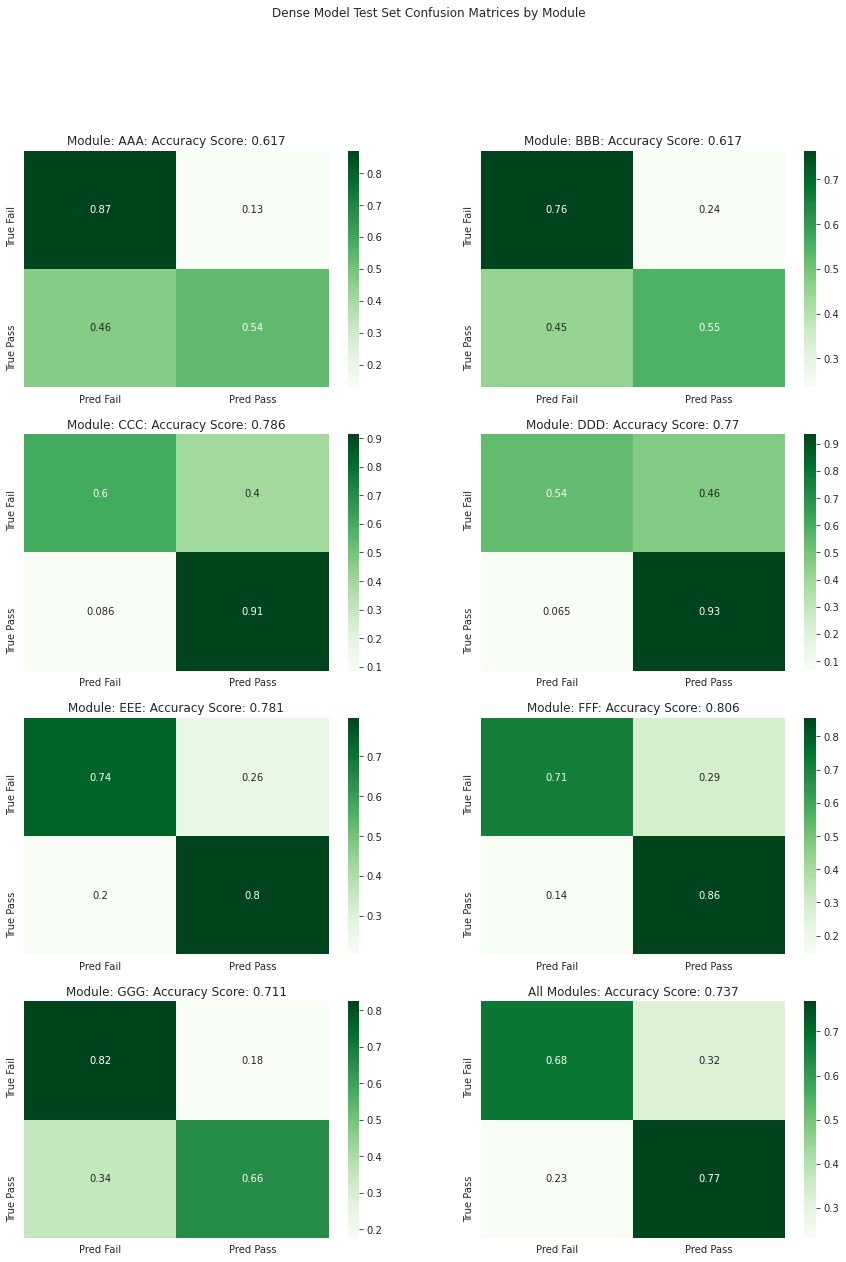

In [98]:
model = keras.models.load_model(f'../models/DNNmodelJP.h5')
y_pred = np.round(model.predict(X_test_transformed))
eval_df = test_df
eval_df['final_result'] = y_test_binary
eval_df['prediction'] = y_pred.astype(int)
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'], index = modules)
fig, axes = plt.subplots(4,2, figsize = (15,20))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = accuracy_score(trues,preds)
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'Module: {module}: Accuracy Score: {round(accuracy,3)}')
    axes[i].set_yticklabels(['True Fail', 'True Pass'])
    axes[i].set_xticklabels(['Pred Fail','Pred Pass'])
plot_confusion(y_test_binary, y_pred, ax = axes[-1])
accuracy = accuracy_score(y_test_binary, y_pred)
axes[-1].set_title(f'All Modules: Accuracy Score: {round(accuracy,3)}')
axes[-1].set_yticklabels(['True Fail', 'True Pass'])
axes[-1].set_xticklabels(['Pred Fail','Pred Pass'])
plt.tight_layout(rect = [0,0,0,0])
plt.savefig('../figures/jp_course_confmats.png')
plt.suptitle(f'Dense Model Test Set Confusion Matrices by Module')
plt.show()

#### Patrones de Error por Variable Predictora

244/244 [==============================] - 2s 5ms/step


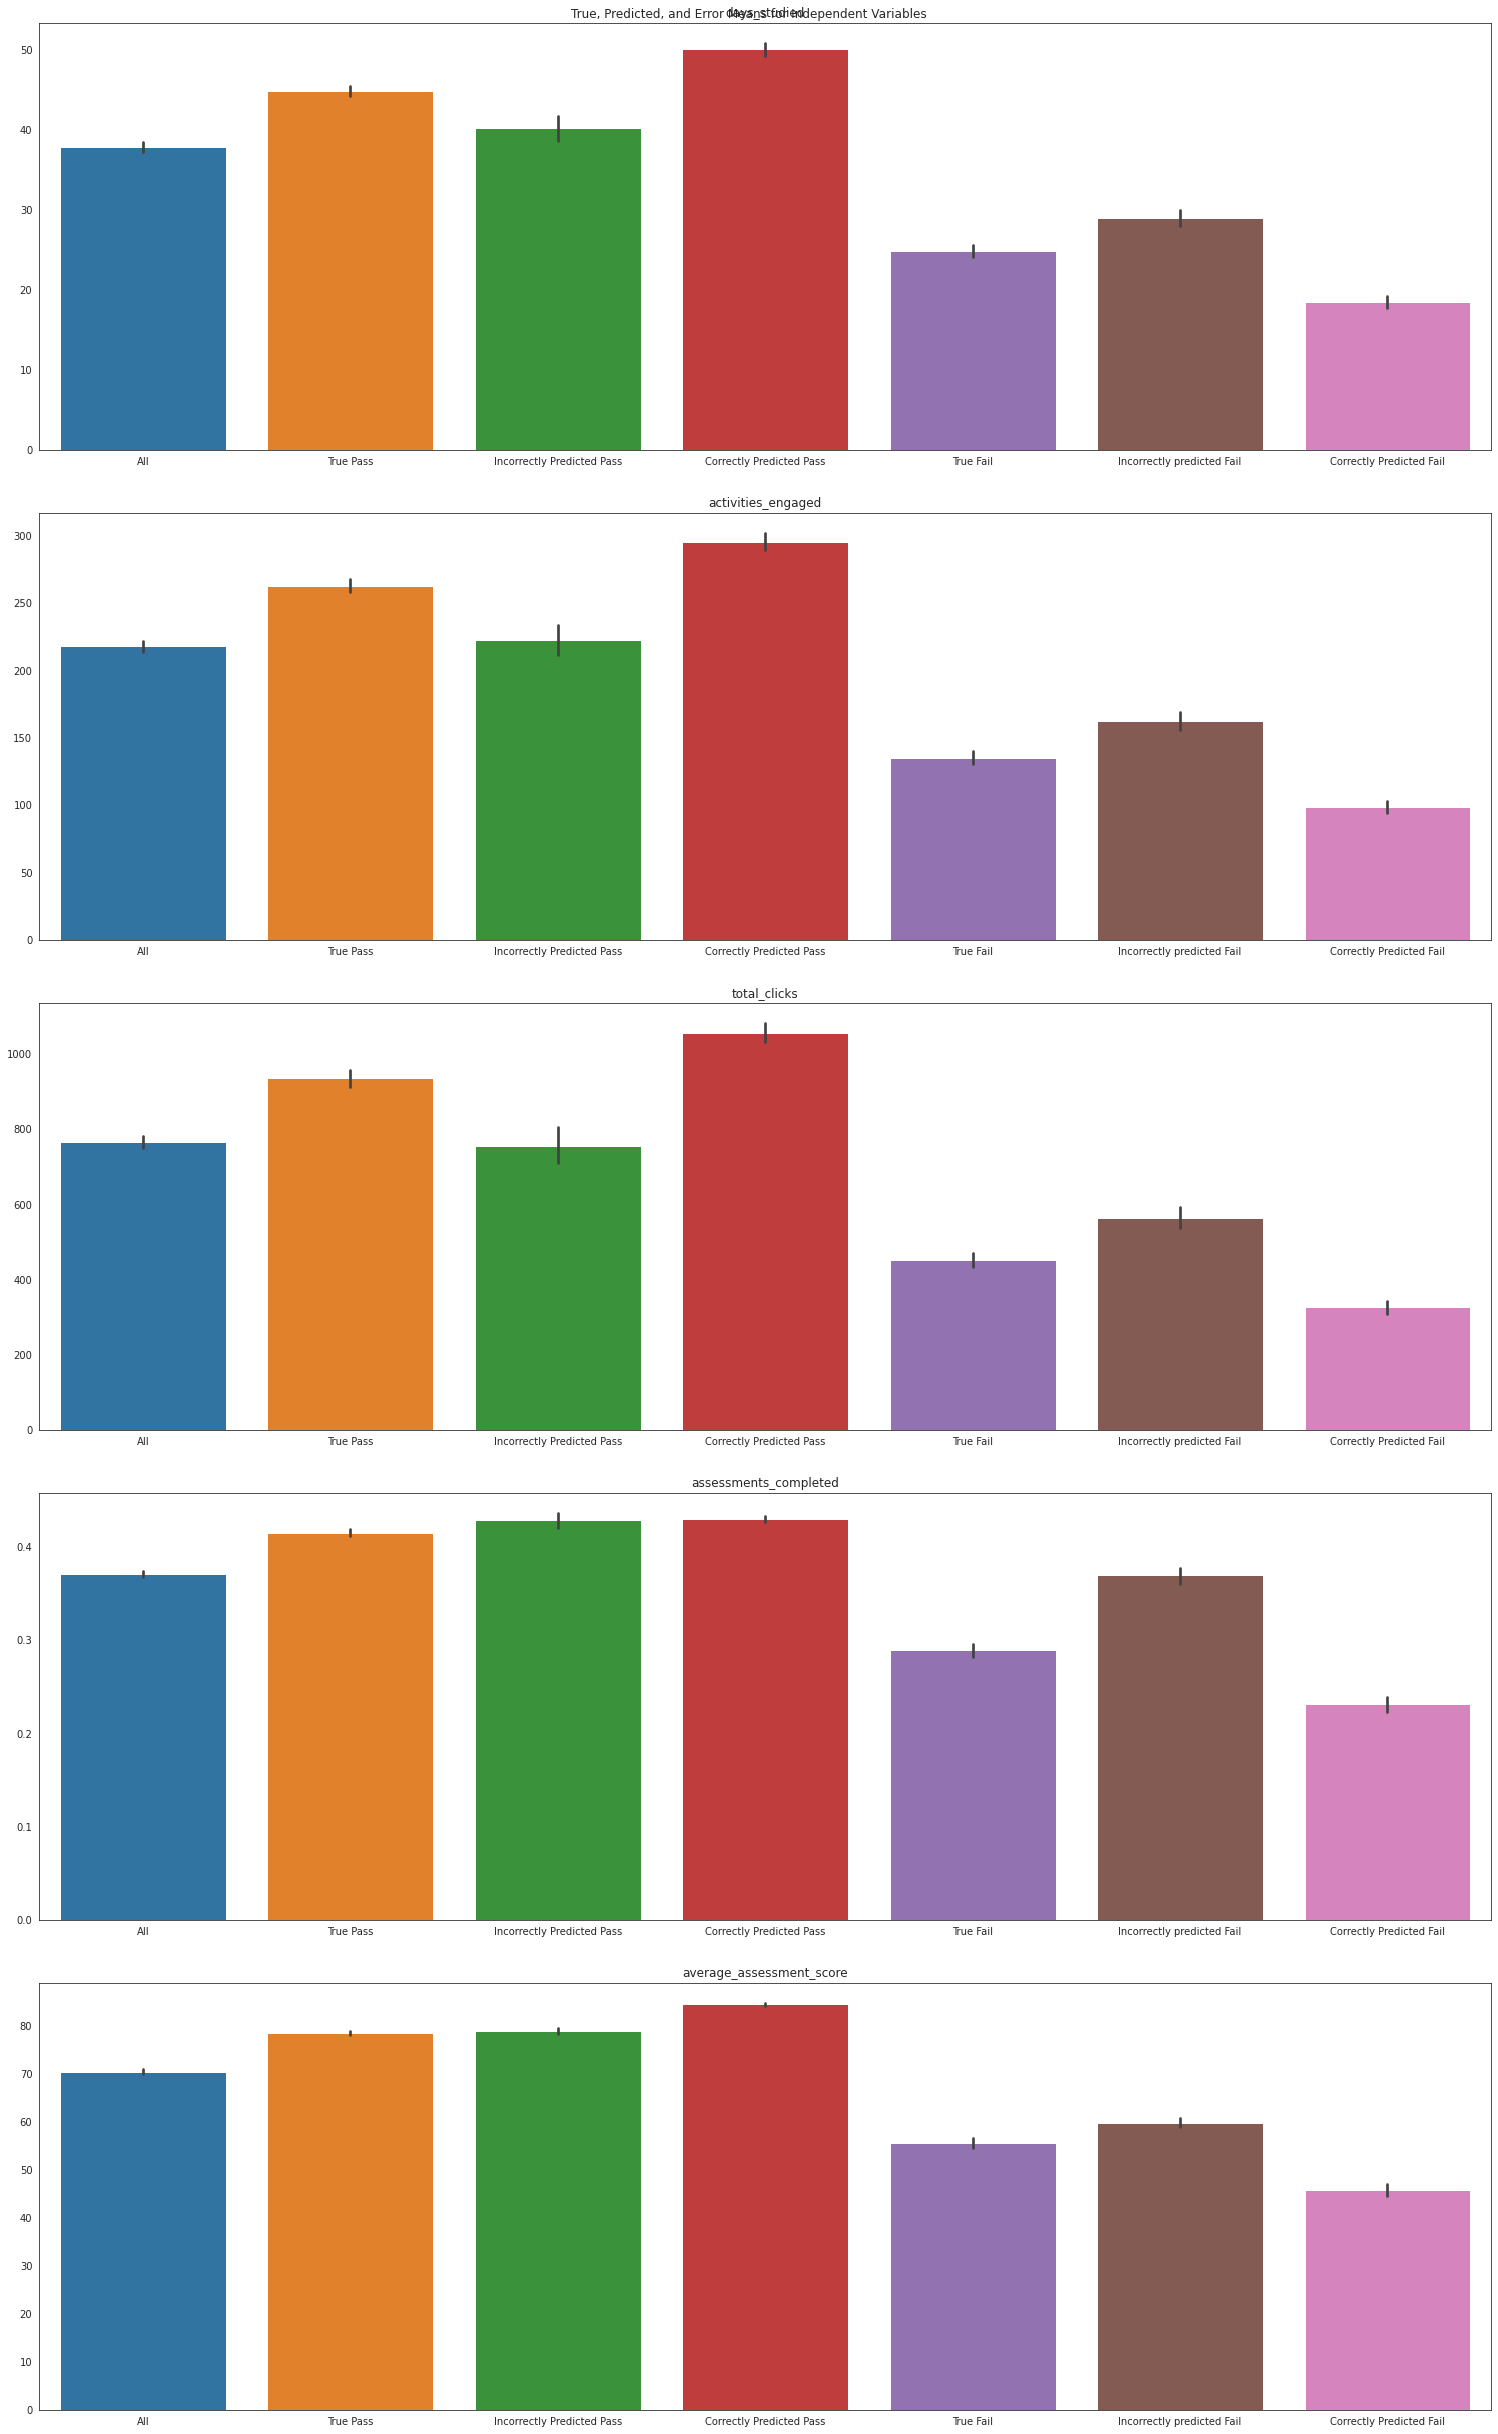

In [107]:
evaluation = X_test.copy()
model = load_model('../models/densemodel8.h5')
evaluation['result'] = y_test_binary
evaluation['Prediction'] = np.round(model.predict(X_test_transformed_deep))
evaluation['true uncollapsed'] = y_test_uncollapsed

fig, axes = plt.subplots(5,1, figsize = (22,35))
axes = axes.ravel()
for i, column in enumerate(X_test.columns[1:]):
    to_graph = pd.DataFrame()
    to_graph['All'] = evaluation[column]
    to_graph['True Pass'] = evaluation[evaluation['result'] == 1][column]
    to_graph['Incorrectly Predicted Pass'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 1)][column]    
    to_graph['Correctly Predicted Pass'] = evaluation[(evaluation['Prediction'] == 1)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]
    to_graph['True Fail'] = evaluation[evaluation['result'] == 0][column]
    to_graph['Incorrectly predicted Fail'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 0)][column]    
    to_graph['Correctly Predicted Fail'] = evaluation[(evaluation['Prediction'] == 0)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]

    
    sns.barplot(data = to_graph, ax = axes[i])
    axes[i].set(title=column)
    
fig.tight_layout(pad = 5, h_pad = 3, w_pad = 5)
plt.suptitle('True, Predicted, and Error Means for Independent Variables')
plt.savefig('../figures/true_pred_error_var_means.png', dpi=250)
plt.show()

244/244 [==============================] - 0s 2ms/step


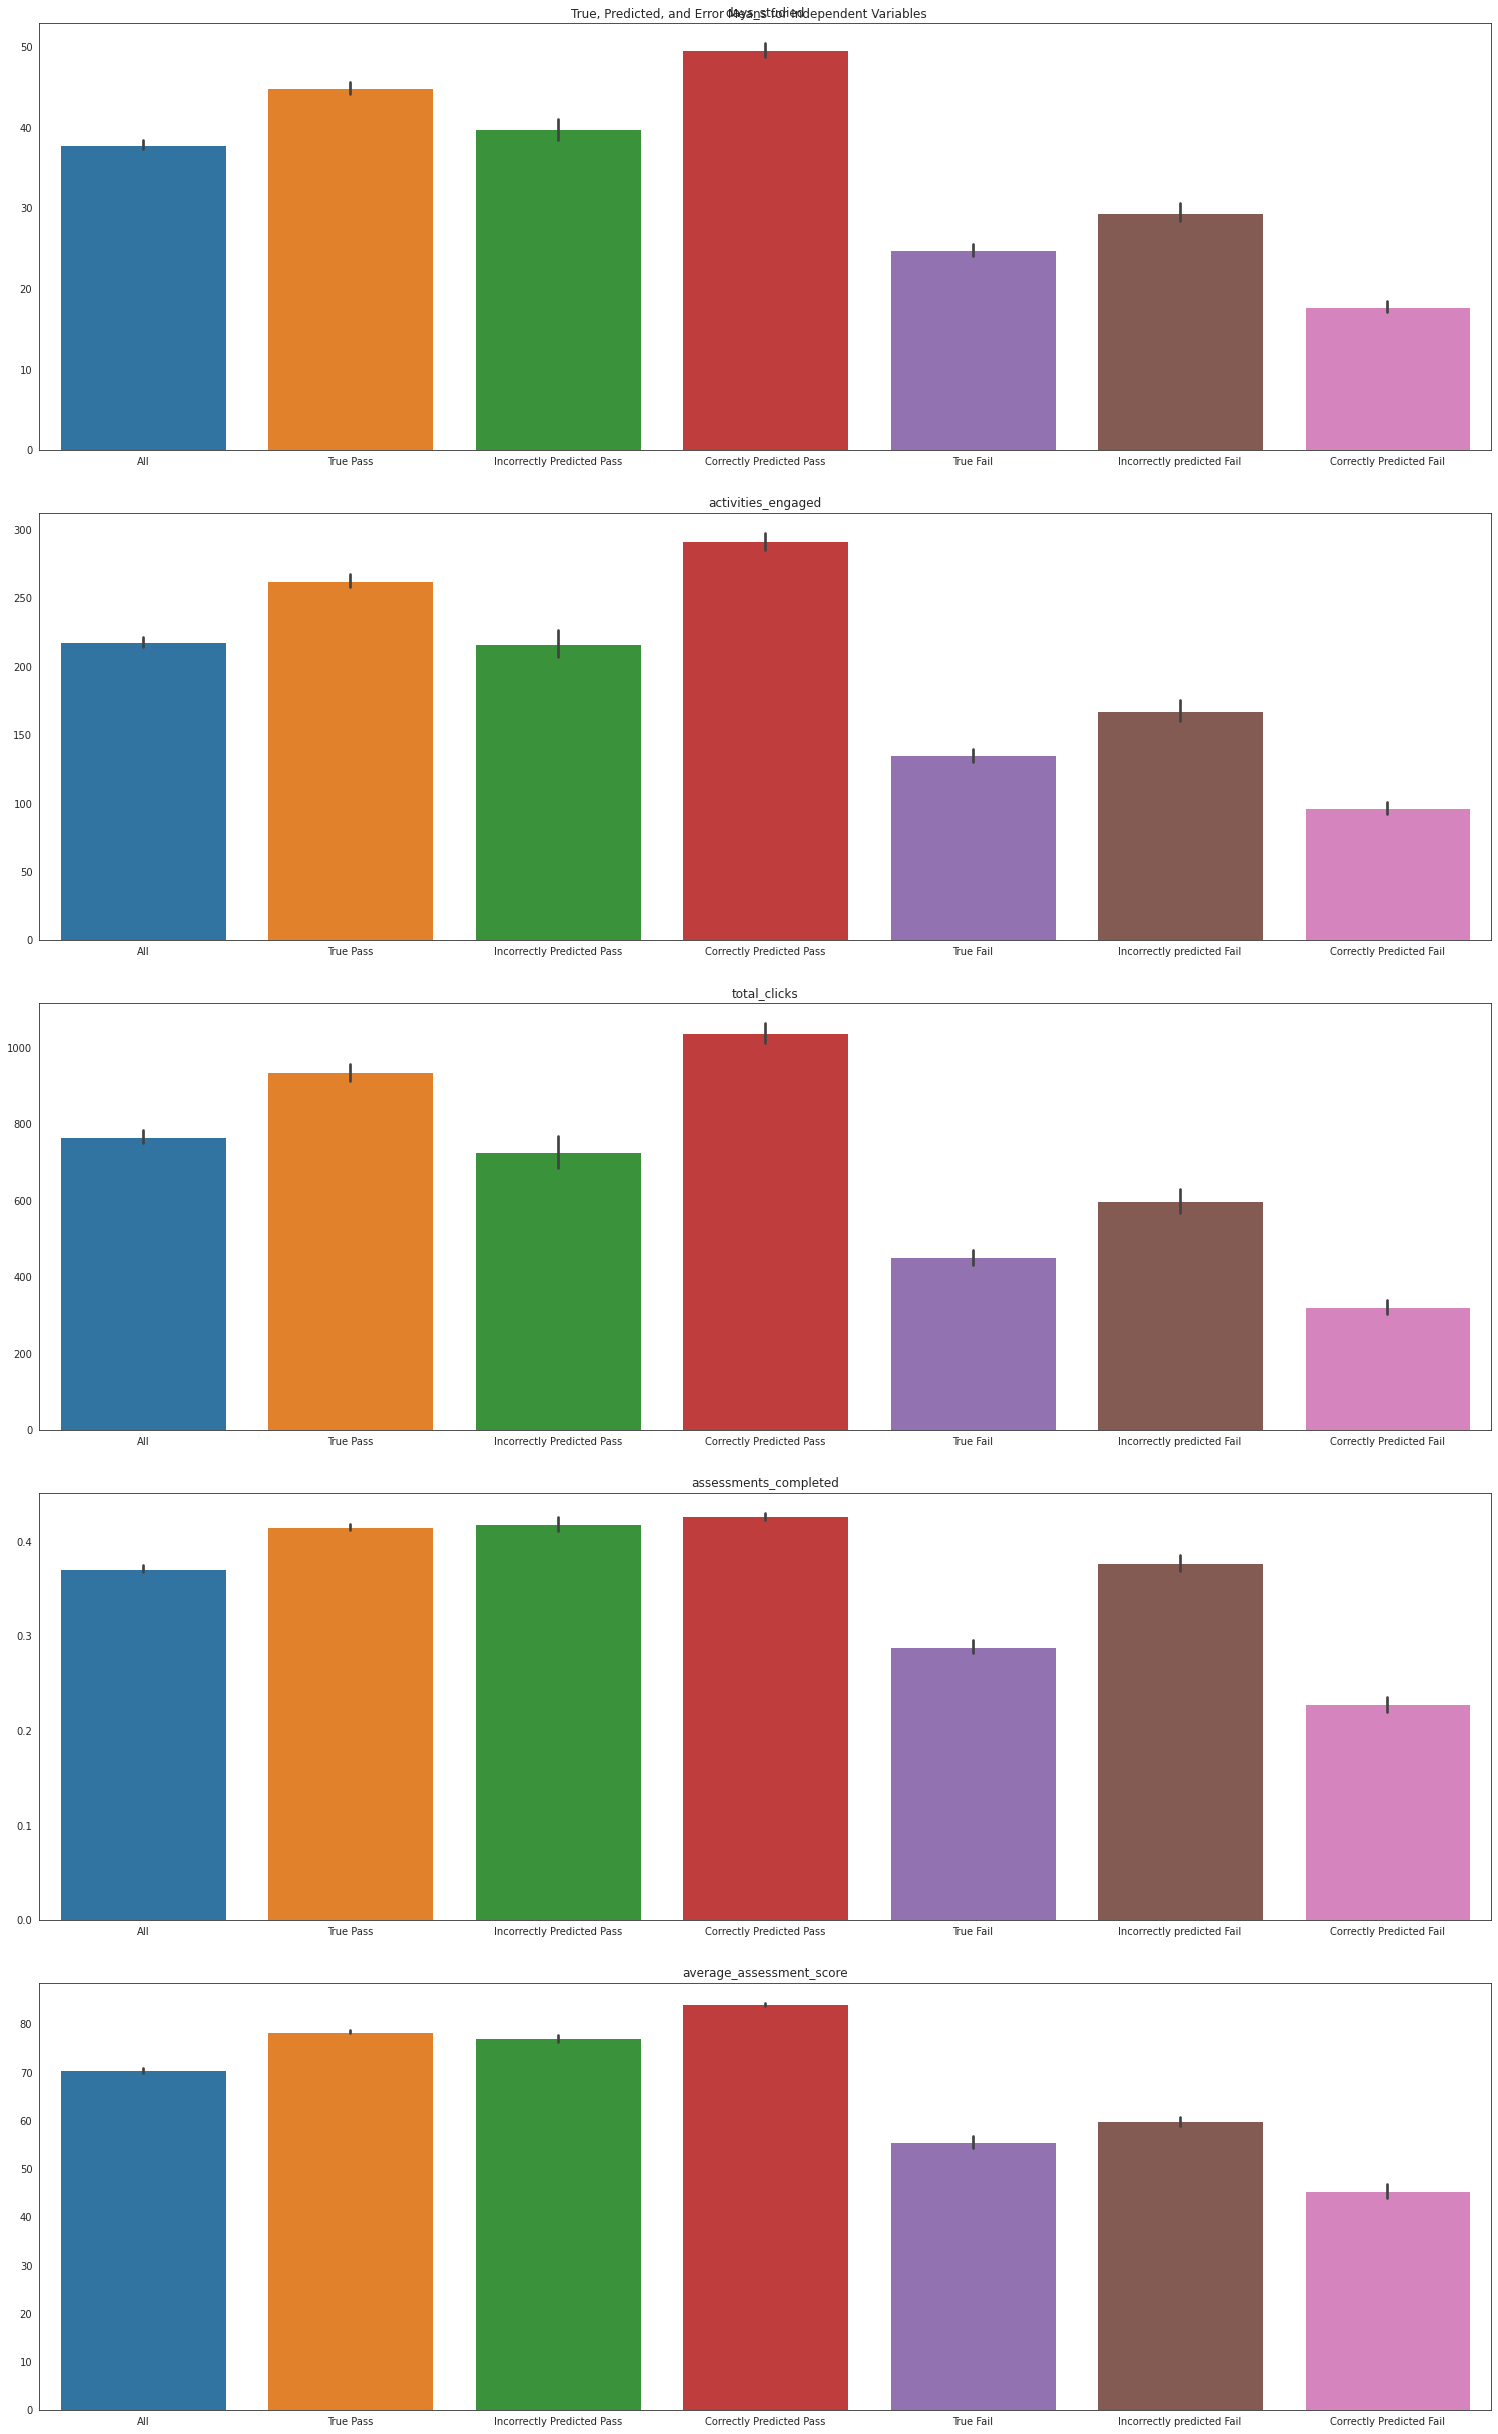

In [110]:
evaluation = X_test.copy()
model = load_model('../models/DNNmodelJP.h5')
evaluation['result'] = y_test_binary
evaluation['Prediction'] = np.round(model.predict(X_test_transformed))
evaluation['true uncollapsed'] = y_test_uncollapsed

fig, axes = plt.subplots(5,1, figsize = (22,35))
axes = axes.ravel()
for i, column in enumerate(X_test.columns[1:]):
    to_graph = pd.DataFrame()
    to_graph['All'] = evaluation[column]
    to_graph['True Pass'] = evaluation[evaluation['result'] == 1][column]
    to_graph['Incorrectly Predicted Pass'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 1)][column]    
    to_graph['Correctly Predicted Pass'] = evaluation[(evaluation['Prediction'] == 1)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]
    to_graph['True Fail'] = evaluation[evaluation['result'] == 0][column]
    to_graph['Incorrectly predicted Fail'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 0)][column]    
    to_graph['Correctly Predicted Fail'] = evaluation[(evaluation['Prediction'] == 0)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]

    
    sns.barplot(data = to_graph, ax = axes[i])
    axes[i].set(title=column)
    
fig.tight_layout(pad = 5, h_pad = 3, w_pad = 5)
plt.suptitle('True, Predicted, and Error Means for Independent Variables')
plt.savefig('../figures/jp_true_pred_error_var_means.png', dpi=250)
plt.show()

#### Clasificaciones Correctas del Conjunto Original

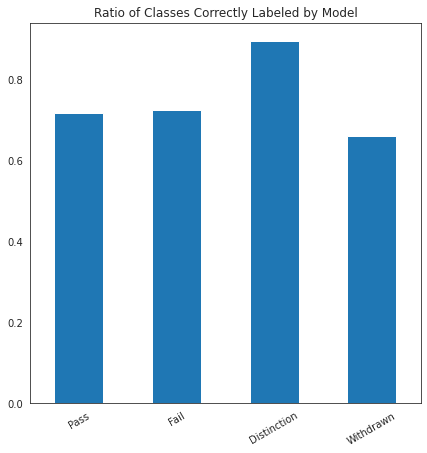

In [108]:
full_class_counts = evaluation['true uncollapsed'].value_counts()
correct_class_counts = evaluation[evaluation['result'] == evaluation['Prediction']]['true uncollapsed'].value_counts()
correct_class_ratio = correct_class_counts/full_class_counts
correct_class_ratio.plot(kind = 'bar', figsize = (7,7), rot = 30)
plt.title('Ratio of Classes Correctly Labeled by Model')
plt.savefig('../figures/ratio_correct_by_class_dense.png', dpi = 100)

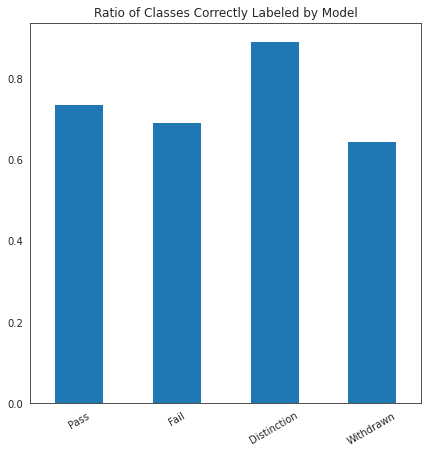

In [112]:
full_class_counts = evaluation['true uncollapsed'].value_counts()
correct_class_counts = evaluation[evaluation['result'] == evaluation['Prediction']]['true uncollapsed'].value_counts()
correct_class_ratio = correct_class_counts/full_class_counts
correct_class_ratio.plot(kind = 'bar', figsize = (7,7), rot = 30)
plt.title('Ratio of Classes Correctly Labeled by Model')
plt.savefig('../figures/ratio_correct_by_class_dense.png', dpi = 100)